# Task

С помощью модели типа "Автокадировщик" детектировать мошеннические транзакции кредитных кард.



In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Dropout
from tensorflow.keras import backend as K       # подтягиваем базовые керасовские функции
from tensorflow.keras.optimizers import Adam    # загружаем выбранный оптимизатор
from tensorflow.keras import utils 

import matplotlib.pyplot as plt 

import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 

import os 
from google.colab import drive 
import time, random
import seaborn as sns

sns.set_style('darkgrid')

In [2]:
!pip install patool
import patoolib   

     |████████████████████████████████| 77 kB 852 kB/s 


In [3]:
drive.mount('/content/drive/') # монтируем google диск

Mounted at /content/drive/


In [4]:
# Разархивируем архив
patoolib.extract_archive('/content/drive/MyDrive/DataSets/creditcard.rar', outdir='/content' )

patool: Extracting /content/drive/MyDrive/DataSets/creditcard.rar ...
patool: running /usr/bin/unrar x -- /content/drive/MyDrive/DataSets/creditcard.rar
patool:     with cwd='/content'
patool: ... /content/drive/MyDrive/DataSets/creditcard.rar extracted to `/content'.


'/content'

In [5]:
df = pd.read_csv("/content/creditcard.csv") # читаем базу

In [6]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


# Preprocessing

In [7]:
# Удаляем столбец со временем
data = df.drop(['Time'], axis=1)
# Нормализуем столбец с суммой транзакции
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

# разделяем транзакции на мошеннические/нормальные
frauds = data[data.Class == 1] 
normal = data[data.Class == 0] 

print('Количество  мошеннических трмнзакций:' , frauds.shape[0]) # смотрим какие размеры у мошеннических операций
print('Количество  нормальных трмнзакций:' ,normal.shape[0]) # смотрим какие размеры у нормальных операций

Количество  мошеннических трмнзакций: 492
Количество  нормальных трмнзакций: 284315


# Short Plan

**- Очевиден огромных дизбаланс классов.**

**- Поэтому в качесте модели детекции мошеннических транзакций будем использовать автокодировщик, который будет обучаться только на нормальных транзакциях.**

**- В итоге мы получим модель, которая, получив на вход нормальные транзакции, с высокой точностью их восстановит, а ошибка будет минимальной.**

**- С другой стороны, если на данную модель подать ошибочные транзакции, то у неё не получится в полной мере их восстановить, а ошибка будет большой.**

**- Таким образом по величине ошибки можно будет определить к какому типу относится транзакция.**

**- Так же важно будет подобрать пороговое значение bias. Его роль заключатся в том, что транзакция, на которой величина ошибки выше данного bias, будет отнесена к мошенничесим, если величина ошибки ниже, то к нормальным.**

**- Найти оптимальный bias.**

In [9]:
##################################################################
# Разбиваем нормальные транзакции на обучающую и тестовую выборки.
##################################################################

RANDOM_SEED = 42 
X_train, X_test = train_test_split(normal, test_size=0.2, random_state=RANDOM_SEED)

In [10]:
# Удаляем метки в обучающем наборе данных
X_train = X_train.drop(['Class'], axis=1)

# Добавляем все мошеннические транзакции в тестовый набор данных
X_test = pd.concat([X_test, frauds])

# Создаем массив из одних меток
y_test = X_test['Class']

# Удаляем метки у тестового набора данных
X_test = X_test.drop(['Class'], axis=1)

# Преобразуем данные в массивы numpy
X_train = X_train.values
X_test = X_test.values

In [11]:
print(X_train.shape) # взглянем на размеры обучающих данных

(227452, 29)


# Modelling

In [74]:
def creditcardAutoencoder(): # объявляем автокодировщик для определения мошенич.транзакций
  dataSize = X_train.shape[1] # берём размеры X_train по второй оси(30)
  dataInput = Input(shape=(dataSize, )) # задаем эти размеры как входные в сеть
  
  x = Dense(dataSize, activation='relu')(dataInput) # пропускаем через полносвязный слой размером 10
  x = Dense(32, activation='relu')(x) # пропускаем через полносвязный слой размером 1
  x = Dropout(0.1)(x)
  x = Dense(128, activation='relu')(x) # пропускаем через полносвязный слой размером 1
  x = Dropout(0.1)(x)
  x = Dense(32, activation='relu')(x) # пропускаем через полносвязный слой размером 1
  x = Dropout(0.1)(x)
  x = Dense(dataSize, activation='linear')(x) # и через полносвязный слой размером 29 
  
  autoencoder = Model(inputs=dataInput, outputs=x) # собрали модель 
  
  autoencoder.compile(optimizer=Adam(learning_rate=0.001,), loss='mse') # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки
  
  return autoencoder 

In [75]:
# model.compile()

In [76]:
model = creditcardAutoencoder()

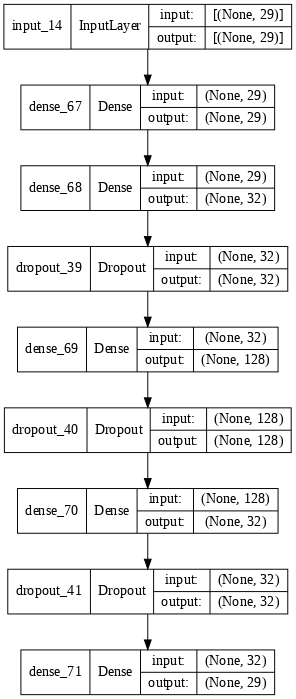

In [77]:
utils.plot_model(model, dpi=70, show_shapes=True)

In [25]:
history = model.fit(X_train, X_train,
                    epochs=50,
                    batch_size=256) # загружаем данные в модель(X_train'ы) и обучаем

Epoch 1/50
889/889 [==============================] - 4s 4ms/step - loss: 0.4745
Epoch 2/50
889/889 [==============================] - 4s 4ms/step - loss: 0.3101
Epoch 3/50
889/889 [==============================] - 4s 4ms/step - loss: 0.2721
Epoch 4/50
889/889 [==============================] - 4s 4ms/step - loss: 0.2564
Epoch 5/50
889/889 [==============================] - 4s 4ms/step - loss: 0.2408
Epoch 6/50
889/889 [==============================] - 4s 4ms/step - loss: 0.2316
Epoch 7/50
889/889 [==============================] - 4s 4ms/step - loss: 0.2249
Epoch 8/50
889/889 [==============================] - 4s 4ms/step - loss: 0.2192
Epoch 9/50
889/889 [==============================] - 4s 4ms/step - loss: 0.2170
Epoch 10/50
889/889 [==============================] - 4s 4ms/step - loss: 0.2104
Epoch 11/50
889/889 [==============================] - 4s 4ms/step - loss: 0.2053
Epoch 12/50
889/889 [==============================] - 4s 4ms/step - loss: 0.2042
Epoch 13/50
889/889 [====

In [26]:
model.save_weights('/content/drive/MyDrive/Модели/modelCredit.h5') # Сохраняем веса модели


In [78]:
model.load_weights('/content/drive/MyDrive/Модели/modelCredit.h5') # Загружаем веса модели

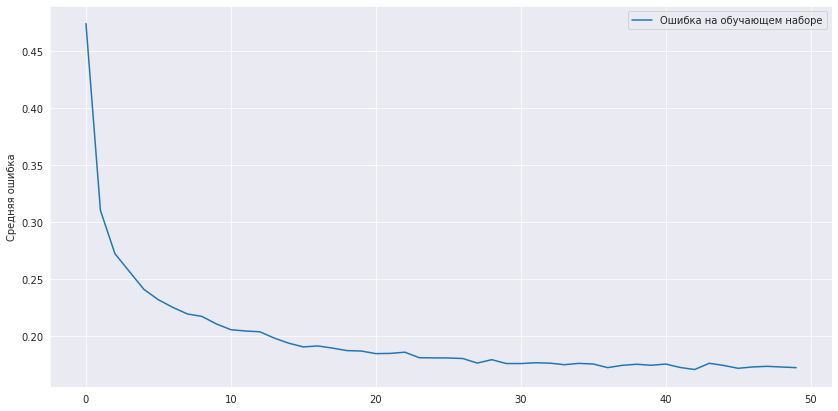

In [28]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [79]:
predictions = model.predict(X_test) # делаем предсказание по X_test

In [81]:
X_test[0]

array([ 1.31453919,  0.59064276, -0.66659342,  0.71656434,  0.30197787,
       -1.12546747,  0.38888053, -0.28838964, -0.13213745, -0.59773893,
       -0.32534664, -0.21643538,  0.08420408, -1.05463056,  0.96793203,
        0.60122627,  0.63111664,  0.29507797, -0.1361507 , -0.05804041,
       -0.17030728, -0.42965504, -0.14134068, -0.20019463,  0.63949149,
        0.39947569, -0.03432101,  0.03169241, -0.35019085])

**Определяем среднеквадратичную ошибку по X_test и предсказанием по X_test**

In [84]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1) 

**Анализируем предсказания на тестовой выборке**

In [85]:
mse_normal = mse[y_test.values == 0] # среднеквадратичная ошибка на нормальных операциях
mse_frauds = mse[y_test.values == 1] # среднеквадратичная ошибка на мошеннических операциях

In [86]:
print("Минимальная ошибка нормальных транзакций:", round(min(mse_normal),4)) #найдем минимальную среднеквадратичную ошибку на нормальных операциях
print("Максимальная ошибка нормальных транзакций:", round(max(mse_normal),4)) #найдем максимальную среднеквадратичную ошибку на нормальных операциях
print("Средняя ошибка нормальных транзакций:", round(sum(mse_normal) / len(mse_normal),4)) # среднюю ошибку

Минимальная ошибка нормальных транзакций: 0.0046
Максимальная ошибка нормальных транзакций: 141.8194
Средняя ошибка нормальных транзакций: 0.0735


In [87]:
print("Минимальная ошибка мошеннических транзакций:", round(min(mse_frauds),4)) #найдем минимальную среднеквадратичную ошибку на мошеннических операциях
print("Максимальная ошибка мошеннических транзакций:", round(max(mse_frauds),4)) #найдем максимальную среднеквадратичную ошибку на мошеннических операциях
print("Средняя ошибка мошеннических транзакций:", round(sum(mse_frauds) / len(mse_frauds),4)) # среднюю ошибку

Минимальная ошибка мошеннических транзакций: 0.0121
Максимальная ошибка мошеннических транзакций: 72.7978
Средняя ошибка мошеннических транзакций: 17.2829


# bias selection

In [123]:
####################################################
# Функция возвращает список точностей распознавания.
####################################################

def getAccByBias(bias): # функция будет принимать какое то пороговое значение
  isNormal = mse_normal < bias # если ошибка меньше порога - то транзакция нормальная
  isFrauds = mse_frauds > bias # если ошибка больше порога - то транзакция мошенническая

  accNormal = sum(isNormal) / len(isNormal) # вычисляем процент нормальных операций
  accNormal = round(100*accNormal)

  accFaruds = sum(isFrauds) / len(isFrauds) # вычисляем процент мошеннических операций
  accFaruds = round(100*accFaruds)

  acc_all = round((accNormal + accFaruds)/2) # вычисляется общая точность распознавания


  print("Распознано нормальных транзакций: ", accNormal, "%", sep="")
  print("Распознано мошеннических транзакций: ", accFaruds, "%", sep="")
  print("Средняя точность распознавания: ", acc_all, "%", sep="")  

  return [accNormal, accFaruds, acc_all]



In [117]:
# Удостоверимся, что точность оптимальна
getAccByBias(0.10) # выведем данные по распознаванию с конкретным пороговым значением

Распознано нормальных транзакций: 89%
Распознано мошеннических транзакций: 90%
Средняя точность распознавания: 90%


[89, 90, 90]

In [119]:
####################################################
# Функция возвращает список точностей распознавания.
####################################################

def getAccByBias(bias): # функция будет принимать какое то пороговое значение
  isNormal = mse_normal < bias # если ошибка меньше порога - то транзакция нормальная
  isFrauds = mse_frauds > bias # если ошибка больше порога - то транзакция мошенническая

  accNormal = sum(isNormal) / len(isNormal) # вычисляем процент нормальных операций
  accNormal = round(100*accNormal)

  accFaruds = sum(isFrauds) / len(isFrauds) # вычисляем процент мошеннических операций
  accFaruds = round(100*accFaruds)

  acc_all = round((accNormal + accFaruds)/2) # вычисляется общая точность распознавания

  return [accNormal, accFaruds, acc_all]

In [120]:
#Создаем массивы
y_true =  []#массив ошибок на нормальных опрациях
y_false = []#массив ошибок на ложных операциях
x_bias =  []#массив биасов, соответствующих ошибкам
for i in np.arange(0, 3, 0.05):
  a = getAccByBias(i)[0]
  b = getAccByBias(i)[1]
  y_true.append(a)
  y_false.append(b)
  x_bias.append(i)



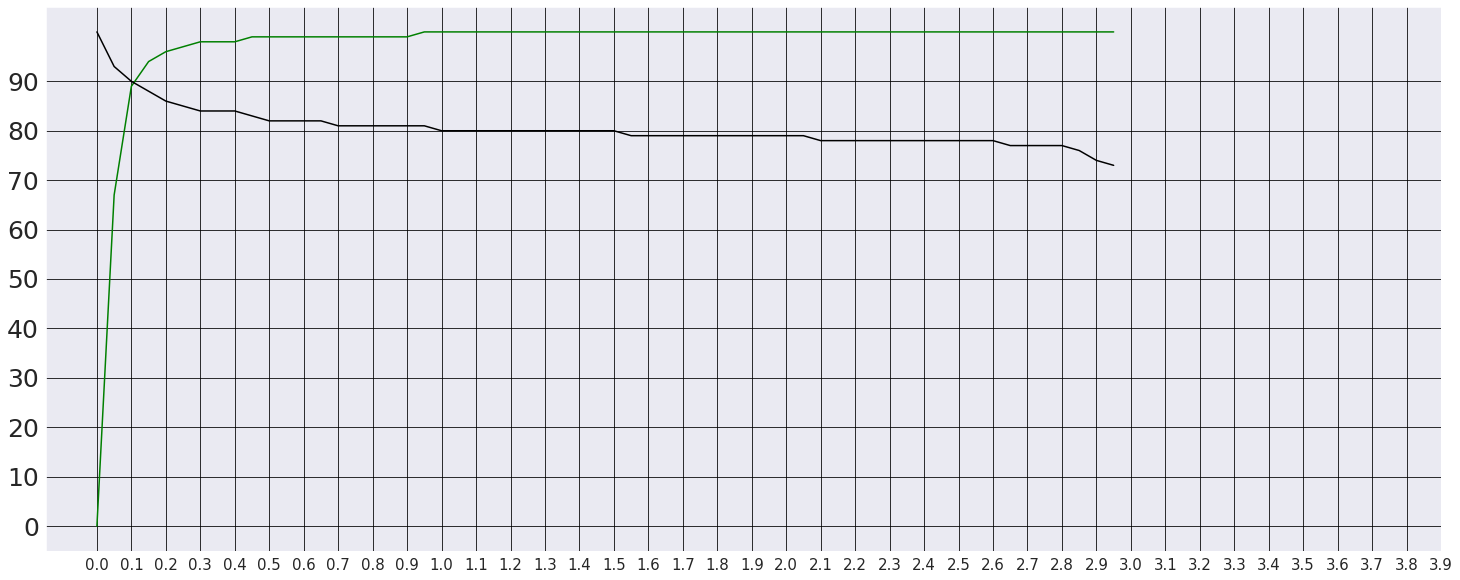

In [121]:
# Строим графики зависимости ошибки от изменения биаса
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(111)
ax.plot(x_bias,y_true, color = 'green')
ax.plot(x_bias,y_false,color = 'black')

ax.grid(which='major',
        color = 'k')

plt.xticks(np.arange(min(x_bias), max(x_bias)+1, 0.1),fontsize=15)
plt.yticks(np.arange(0,100,10),fontsize=25)

plt.show()

In [124]:
getAccByBias(0.10)

Распознано нормальных транзакций: 89%
Распознано мошеннических транзакций: 90%
Средняя точность распознавания: 90%


[89, 90, 90]

**Оптимальный bias: 0.1 - пересечение графиков ошибок**
